# Zustandsregelung - Teil 2

LV Elektronische Steuerungs- und Regelungssysteme SS2020 (Master ETuIT, HSM, (c) Christoph Menz) 

***

Im ersten Teil (Einführung Python Control Systems Library) haben wir bereits einen Zustandsregler für einen Gleichstrommotor entworfen, der in der Lage ist, Auslenkungen aus der Ruhelage $\varphi = 0$ auszuregeln. In diesem Teil wollen wir auf die Vorgabe von Führungsgrößen eingehen.  

***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import control as ctrl

***

### Vorfilter

Eine Möglichkeit, Führungsgrößen vorzugeben, besteht darin ein sog. Vorfilter zu entwerfen. Der Ansatz besteht darin, dass wir die Führungsgröße(n) $\mathbf{w}$ mit einer Vorfilter-Matrix $S$ gewichten:

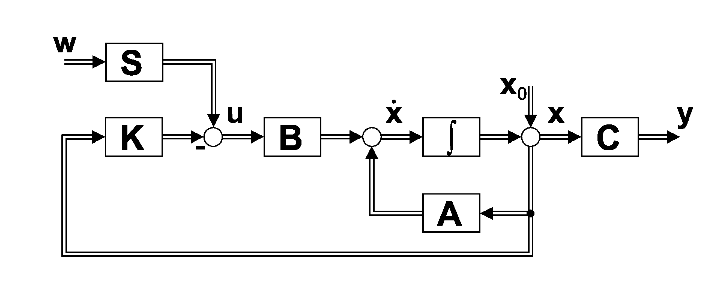

In [2]:
image = mpimg.imread("Vorfilter.png")
plt.figure(figsize=(12,6))
plt.imshow(image)
plt.axis('off')
plt.show()

$
\mathbf{u} = \mathbf{S} \mathbf{w} - \mathbf{K} \mathbf{x} 
$

Setzen wir dies in unser System ein, ist

$
\dot{\mathbf{x}} = \mathbf{A} \mathbf{x} + \mathbf{B} \mathbf{S} \mathbf{w} - \mathbf{B} \mathbf{K} \mathbf{x}   
$

Im stationären bzw. ausgeregelten Zustand ist $\dot{\mathbf{x}} = \mathbf{0}$

$
\begin{align}
\mathbf{0} &= \mathbf{A} \mathbf{x} + \mathbf{B} \mathbf{S} \mathbf{w} - \mathbf{B} \mathbf{K} \mathbf{x}   
\\
\mathbf{0} &= (\mathbf{A} - \mathbf{B} \mathbf{K}) \mathbf{x} + \mathbf{B} \mathbf{S} \mathbf{w} 
\\
(\mathbf{B} \mathbf{K} - \mathbf{A}) \mathbf{x} &= \mathbf{B} \mathbf{S} \mathbf{w} 
\\
\mathbf{x} &= (\mathbf{B} \mathbf{K} - \mathbf{A})^{-1} \mathbf{B} \mathbf{S} \mathbf{w} 
\end{align}
$

Da gelten soll

$
\mathbf{y} = \mathbf{w} = \mathbf{C}\mathbf{x}
$

ist

$
\mathbf{w} = \mathbf{C}(\mathbf{B} \mathbf{K} - \mathbf{A})^{-1} \mathbf{B} \mathbf{S} \mathbf{w} 
$


Diese Forderung ist erfüllt, wenn

$
\mathbf{I} = \mathbf{C}(\mathbf{B} \mathbf{K} - \mathbf{A})^{-1} \mathbf{B} \mathbf{S} 
$

und damit (wenn die Anzahl der Stellgrößen gleich der Anzahl der Ausgänge ist)

$
\mathbf{S} = (\mathbf{C}(\mathbf{B} \mathbf{K} - \mathbf{A})^{-1} \mathbf{B})^{-1} 
$

#### System Gleichstrommotor

In [80]:
# Parameter
R = 1
L = 0.01
J = 0.1
km = 1
kr = 1

# System
A = [[0.,1.,0.],[0,-kr/J,km/J],[0,-km/L,-R/L]]
b = [[0],[0],[1/L]]
c = [[1,0,0]]
d = [0]

# Erzeugung eines ZR-Modells mit der Control Systemes Library
sys = ctrl.ss(A,b,c,d)

# Eigenwerte festlegen
p = [-10,-15,-20]

# Reglermatrix berechnen
K = ctrl.place(A,b,p)

# Vorfilter berechnen
BK_A = np.linalg.inv(np.dot(b,K)-A)
S_inv = np.dot(c,np.dot(BK_A,b))
S = np.linalg.inv(S_inv) 

print("S = " + str(S))

S = [[3.]]


#### Simulation

In [4]:
dt = 0.001 
t = np.arange(0,1+dt,dt) 

u = np.zeros(len(t)) # Eingangsgröße 
x = np.zeros([len(t)+1,3]) # Zustandsgrößen
y = np.zeros(len(t)) # Ausgangsgröße

# Sollwerte
w = 1.0 + np.zeros(len(t)) 

for k in range(len(t)):
    
    # Stellgröße berechnen 
    u[k] = np.dot(S,w[k]) - np.dot(K,x[k])
    # System simulieren (Euler)
    dx = np.dot(A,x[k]) + np.dot(b,u[k]).T
    x[k+1] = x[k] + dx*dt
    # Ausgangsgröße
    y[k] = np.dot(c,x[k])

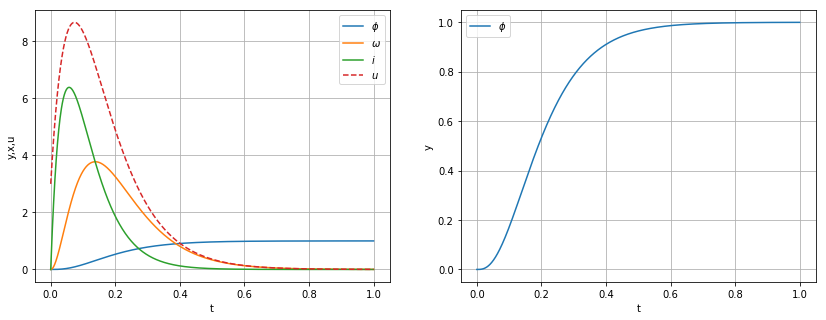

In [5]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(t, y)
plt.plot(t, x[:len(t),1])
plt.plot(t, x[:len(t),2])
plt.plot(t, u, '--')
plt.grid()
plt.xlabel('t')
plt.ylabel('y,x,u')
plt.legend(['$\phi$','$\omega$','$i$','$u$'])
plt.subplot(1,2,2)
plt.plot(t, y)
plt.grid()
plt.xlabel('t')
plt.ylabel('y')
plt.legend(['$\phi$'])
plt.show()

***

### Integrale Ausgangsrückführung

Der gezeigte Ansatz kann bei Störungen oder Modellabweichungen zu bleibenden Abweichungen von der Führugsgröße führen. Durch die zusätzliche Rückführung des Ausgangs in Verbindung mit einem I-Regler kann dies unterbunden werden. 

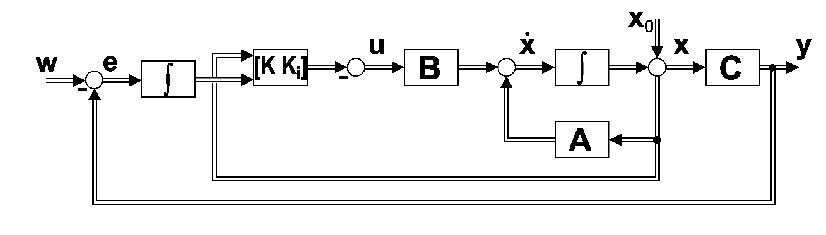

In [6]:
image = mpimg.imread("Ausgangsrueckfuehrung.png")
plt.figure(figsize=(14,5))
plt.imshow(image)
plt.axis('off')
plt.show()

Formal kann der integrierte Fehler einfach dem Zustandsvektor zugeordnet werden. 

$
\mathbf{e} =  \mathbf{w} - \mathbf{y} 
$

$
\mathbf{e} =  \mathbf{w} - \mathbf{C} \mathbf{x} 
$

$
\int \mathbf{e} =  \int \mathbf{w} - \mathbf{C} \mathbf{x}  
$

$
\mathbf{x} = \begin{bmatrix}{ \varphi \\ \omega \\ i \\ \int \mathbf{e}} \end{bmatrix} ,
$ 

Dies führt zu dem erweiterten System

$
\dot{\mathbf{x}}_{erw} = 
\begin{bmatrix}
\mathbf{A} & \mathbf{0} \\
-\mathbf{C} & \mathbf{0} 
\end{bmatrix}
\mathbf{x}_{erw} 
+
\begin{bmatrix}
\mathbf{B} \\
\mathbf{0} 
\end{bmatrix}
\mathbf{u} 
+
\begin{bmatrix}
\mathbf{0} \\
\mathbf{w} 
\end{bmatrix}
$

Der Reglerentwurf erfolgt wie gehabt, jedoch auf Basis der erweiterten Matrizen.  

#### System Gleichstrommotor

In [84]:
# Parameter
R = 1
L = 0.01
J = 0.1
km = 1
kr = 1

# test
c = [[2,0,0]]

# erweitertes System
Aerw = [[0.,1.,0.,0],[0,-kr/J,km/J,0],[0,-km/L,-R/L,0],np.hstack([np.array(c[0])*-1,0])]
berw = [[0],[0],[1/L],[0]]

# Eigenwerte festlegen
perw = [-50,-15,-20,-25]

# Reglermatrix berechnen
Kerw = ctrl.place(Aerw,berw,perw)
print("Kerw = " + str(Kerw))

Kerw = [[ 6.62500000e+01  2.17500000e+00 -1.11022302e-16 -1.87500000e+02]]


c:\program files\python36\lib\site-packages\slycot\synthesis.py:170: UserWarning: 1 violations of the numerical stability condition occured during the assignment of eigenvalues
  warnings.warn('%i violations of the numerical stability condition occured during the assignment of eigenvalues' % warn)


#### Simulation

In [97]:
dt = 0.0001 
t = np.arange(0,1+dt,dt) 

u = np.zeros(len(t)) # Eingangsgröße
x = np.zeros([len(t)+1,3]) # Zustandsgrößen
y = np.zeros(len(t)) # Ausgangsgröße

x[0,0] = -0
y[0] = np.dot(c,x[0])

# Sollwert
w = 2.0

# Fehler integriert - für stationären Anfangszustand initalisieren 
ei = -Kerw[0,0]*x[0,0]/Kerw[0,3]

for k in range(len(t)):
    
    # Abweichung 
    if(k > 0):
        e = w - y[k-1] 
        ei += e*dt
    # Zustandsvektor erweitern
    xerw = np.array([x[k,0],x[k,1],x[k,2],ei])
    # Stellgröße berechnen 
    u[k] = - np.dot(Kerw,xerw)
    
    # System simulieren (Euler)
    dx = np.dot(A,x[k]) + np.dot(b,u[k]).T
    x[k+1] = x[k] + dx*dt
    # Ausgangsgröße
    y[k] = np.dot(c,x[k])

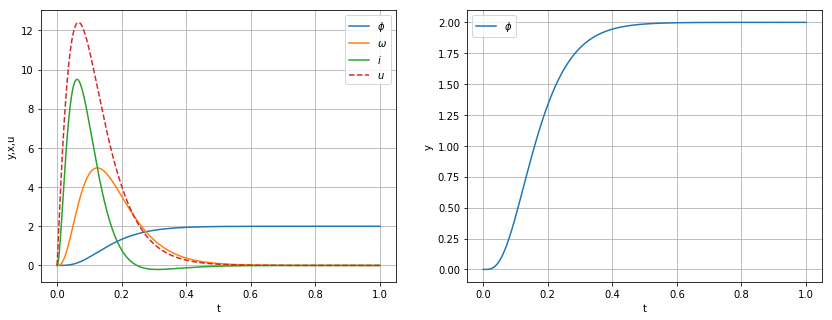

In [96]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(t, y)
plt.plot(t, x[:len(t),1])
plt.plot(t, x[:len(t),2])
plt.plot(t, u, '--')
plt.grid()
plt.xlabel('t')
plt.ylabel('y,x,u')
plt.legend(['$\phi$','$\omega$','$i$','$u$'])
plt.subplot(1,2,2)
plt.plot(t, y)
plt.grid()
plt.xlabel('t')
plt.ylabel('y')
plt.legend(['$\phi$'])
plt.show()